In [1]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
def step(t, dt):
    t = t + dt
    return t

In [3]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

    #     print("x-loc rectangle,", x, "y-loc rectangle,", y)

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [4]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [5]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        
        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self
        
        # calculate the vertical edges of the frame once
        self.view_min_h = self.row_mid - self.height / 2 # up-down edges
        self.view_max_h = self.row_mid + self.height / 2


        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2 # side edges
        view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > view_min and sortedFruit[1,j] < view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_min_h and sortedFruit[2,j] < self.view_max_h:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind.
            
#         self.i_lastFruit = i
        self.i_lastFruit = j
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [6]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [7]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.q_zero        = np.array([q[0],q[1],q[2]])  # arm's zero location (can go back to it)
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([self.q_a[0],self.q_a[1],self.q_a[2]/2])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 1.
        self.a_max         = 10. 
        self.d_max         = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
#     def armStep(self, v_v, q_curr, dt, t):
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # q_curr is the arm's current location within the world frame
        q_curr      = np.array([0.,0.,0.])
        # v_v is the vehicle's velocity
        q_curr[0]   = self.q_a[0]
        q_curr[1]   = self.q_a[1]
        q_curr[2]   = self.q_a[2]

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # check if goal was actually reached
#         if (self.q_a[0] + epsilon < self.goal[0]) or (self.q_a[0] - epsilon > self.goal[0]) and self.goal_r[0] == 1: 
#             self.goal_r[0] = 0
            
#         if (self.q_a[1] + epsilon < self.goal[1]) or (self.q_a[1] - epsilon > self.goal[1]) and self.goal_r[1] == 1: 
#             self.goal_r[1] = 0
            
#         if (self.q_a[2] + epsilon < self.goal[2]) or (self.q_a[2] - epsilon > self.goal[2]) and self.goal_r[2] == 1: 
#             self.goal_r[2] = 0
            
        # update the zero location to follow the vehicle
        self.q_zero[0] += v_v[0]*dt
        self.q_zero[1] += v_v[1]*dt
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         print("")
#         print("ARM:", self.n)
#         print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)
        
#         print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#         print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this 
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
#                 picture.fruitPicked(self.q_a, t)
                row_picture[self.row_n].fruitPicked(self.q_a, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_zero[0]+epsilon or self.q_a[0] < self.q_zero[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_zero[0], self.x.v0, self.v_max, self.a_max, self.d_max)
#         print("RETRACTING")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)       
#         print(" ")
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print(" ")
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is passed the edge of the back frame

            if self.goal[2] < self.z_edges_f[0] and self.goal[2] > self.z_edges_f[1]:
                # check again if the goal is within the top and bottom of the frame
                return 1

            else:
                return 0
        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [8]:
# open CSV file and populate fruits on grid
x_fr = []
y_fr = []
z_fr = []

# with open('Applestotheleft.csv', newline='') as csvfile:
#     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
#     for row in spamreader:
#         x_fr.append(float(row[0]))
#         y_fr.append(float(row[1]))
#         z_fr.append(float(row[2]))
        
with open('Applestotheright.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        x_fr.append(float(row[0]))
        y_fr.append(float(row[1]))
        z_fr.append(float(row[2]))

x_fruit = np.array(x_fr)
y_fruit = np.array(y_fr)
z_fruit = np.array(z_fr)
picked  = np.zeros(len(x_fruit))

# need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
fruit = np.stack([x_fr, y_fr, z_fruit, picked])

rowIndex = 1 # sort based on y-axis
sortedFruit = fruit[ :, fruit[rowIndex].argsort()]


In [9]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

dr = drawRobot()

In [10]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 2.5               # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.003])       # in m, constant velocity

qv0 = []
qv1 = []

In [11]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [12]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [13]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# a = []  # list of arm objects

# for rows in range(num_row_arms):
#     a.append([])

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        q_a_new[0] = q_a[0]             # doesn't change right now
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = q_a[2] + frame_height*rows  # place it over the previous row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows)
        # add the arm to the a-list     
#         a[rows].append(x)
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [14]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
#     picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
#             if a[arm_free].free == 1 and len(picture.fruitBTree) > 0:
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000) #+2
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
    #                     goal_new = picture.fruitBTree.pop(key)
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        sortedFruit[3,goal_new] = 1 
                        # set the new goal
                        a[rows,arm_free].setGoal(sortedFruit[0:3,goal_new], t_new)
                        ### make sure there are available goals left in the b-tree at some point
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break
        
                

                ## look into B-Trees 
                ## https://ebrary.net/25936/computer_science/b-tree_organization
                ## https://cstack.github.io/db_tutorial/parts/part7.html

                ## what happens when there are gaps between trees/fruits => right now it would freeze? => maybe not...
                ## => right now they freeze when they hit that 

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)

#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0,0].x_edges_f[0]))
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 6.3 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 4.0 1.1919865482 0
 
X-axis, Ta: 0.1 Tv: 3.4678696058999994 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.5768304511999999 Td: 0.1
Z-axis, Ta: 0.1 Tv: 2.7080134518 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.9191284757 0
start, end, start velocity: 9.0 7.5732524703 0
start, end, start velocity: 4.0 1.4549112491 0
 
X-axis, Ta: 0.1 Tv: 3.519128475699999 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.3267475297 Td: 0.1
Z-axis, Ta: 0.1 Tv: 2.4450887508999997 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.0836432909 0
start, end, start velocity: 12.0 10.794768294 0
start, end, start velocity: 4.0 0.9577824011 0
 
X-axis, Ta: 0.1 Tv: 2.6836432908999996 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.10523170599999

start, end, start velocity: 9.083643290900001 6.3 0
start, end, start velocity: 9.919128475700001 6.3 0
start, end, start velocity: 9.867869605900001 6.3 0
start, end, start velocity: 6.299999999999998 7.4161710572 0
start, end, start velocity: 6.136835865999994 6.1648153196 0
start, end, start velocity: 5.324488903400041 5.5091652499 0
 
X-axis, Ta: 0.1 Tv: 1.0161710572000016 Td: 0.1
Y-axis, Ta: 0.05289560813527504 Tv: 0 Td: 0.05289560813527504
Z-axis, Ta: 0.1 Tv: 0.084676346499959 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5289560813527504 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.679473099000004 6.3 0
start, end, start velocity: 9.295714183300001 6.3 0
start, end, start velocity: 6.299999999999998 7.8381145569 0
start, end, start velocity: 8.392971928800023 8.4000537743 0
start, end, start velocity: 5.269159458700037 5.2747947104 0
 
X-axis, Ta: 0.1 Tv: 1.4381145569000018 Td: 0.1
Y-axis, Ta: 0.026611737072158657 Tv: 0 Td: 0.02661

start, end, start velocity: 6.299999999999998 8.0151685485 0
start, end, start velocity: 8.512976263700015 8.5566864005 0
start, end, start velocity: 5.179077878830346 5.2130979249 0
 
X-axis, Ta: 0.1 Tv: 1.615168548500002 Td: 0.1
Y-axis, Ta: 0.06611364216255634 Tv: 0 Td: 0.06611364216255634
Z-axis, Ta: 0.058326705778445787 Tv: 0 Td: 0.058326705778445787
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6611364216255634 10.0 10.0
reached values, Z: 0.5832670577844579 10.0 10.0
 
start, end, start velocity: 9.183257204700002 6.3 0
start, end, start velocity: 6.299999999999998 7.5768229295 0
start, end, start velocity: 11.41253923277041 11.4622129926 0
start, end, start velocity: 5.2880159356159355 5.6297854681 0
 
X-axis, Ta: 0.1 Tv: 1.1768229295000014 Td: 0.1
Y-axis, Ta: 0.070479613952965 Tv: 0 Td: 0.070479613952965
Z-axis, Ta: 0.1 Tv: 0.24176953248406416 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7047961395296499 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 


start, end, start velocity: 8.162759697299672 6.3 0
start, end, start velocity: 6.30000000000028 7.6097038563 0
start, end, start velocity: 6.444832933076676 6.4919825658 0
start, end, start velocity: 5.526376693899914 5.5003876913 0
 
X-axis, Ta: 0.1 Tv: 1.2097038562997207 Td: 0.1
Y-axis, Ta: 0.06866559016226659 Tv: 0 Td: 0.06866559016226659
Z-axis, Ta: 0.05097941015735088 Tv: 0 Td: 0.05097941015735088
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6866559016226659 10.0 10.0
reached values, Z: -0.5097941015735088 -10.0 -10.0
 
start, end, start velocity: 9.17144428339949 6.3 0
start, end, start velocity: 6.300000000000274 8.3939796071 0
start, end, start velocity: 10.692433058304763 10.7164582386 0
start, end, start velocity: 4.412695026922034 4.3317924737 0
 
X-axis, Ta: 0.1 Tv: 1.993979607099726 Td: 0.1
Y-axis, Ta: 0.04901548764955469 Tv: 0 Td: 0.04901548764955469
Z-axis, Ta: 0.0899458466089644 Tv: 0 Td: 0.0899458466089644
 
reached values, X: 1.0 10.0 10.0
reached values, 

start, end, start velocity: 6.300000000000336 8.1813010915 0
start, end, start velocity: 9.169140059782132 9.2086837022 0
start, end, start velocity: 5.3170550772379155 5.1432099905 0
 
X-axis, Ta: 0.1 Tv: 1.7813010914996634 Td: 0.1
Y-axis, Ta: 0.06288373590831602 Tv: 0 Td: 0.06288373590831602
Z-axis, Ta: 0.1 Tv: 0.07384508673791554 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6288373590831602 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000000482 10.3387145256 0
start, end, start velocity: 5.502195418511646 5.509697613 0
start, end, start velocity: 2.4956827842998797 1.4868856221 0
 
X-axis, Ta: 0.1 Tv: 3.938714525599518 Td: 0.1
Y-axis, Ta: 0.027390134151467727 Tv: 0 Td: 0.027390134151467727
Z-axis, Ta: 0.1 Tv: 0.9087971621998797 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.27390134151467727 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000000296 8.1109729275 0
start, end

start, end, start velocity: 6.299999999999704 7.5264664522 0
start, end, start velocity: 6.627595328230425 6.6765618552 0
start, end, start velocity: 5.072910422140556 5.4654702567 0
 
X-axis, Ta: 0.1 Tv: 1.126466452200296 Td: 0.1
Y-axis, Ta: 0.0699760866079082 Tv: 0 Td: 0.0699760866079082
Z-axis, Ta: 0.1 Tv: 0.2925598345594441 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6997608660790821 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.5344866263004 6.3 0
start, end, start velocity: 6.299999999999672 8.3021382644 0
start, end, start velocity: 11.077697691000056 11.1025636232 0
start, end, start velocity: 3.488492626999962 3.477485045 0
 
X-axis, Ta: 0.1 Tv: 1.9021382644003277 Td: 0.1
Y-axis, Ta: 0.049865751974620856 Tv: 0 Td: 0.049865751974620856
Z-axis, Ta: 0.03317767622960085 Tv: 0 Td: 0.03317767622960085
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4986575197462086 10.0 10.0
reached values, Z: -0.3317767622960085 -10.0 -10.0
 

start, end, start velocity: 8.092255816900321 6.3 0
start, end, start velocity: 7.937031487400292 6.3 0
start, end, start velocity: 9.771737354400619 6.3 0
start, end, start velocity: 6.299999999999567 8.1181654718 0
start, end, start velocity: 7.983653897900025 8.019408676 0
start, end, start velocity: 4.220265358900127 4.7879724914 0
 
X-axis, Ta: 0.1 Tv: 1.718165471800432 Td: 0.1
Y-axis, Ta: 0.05979529922993489 Tv: 0 Td: 0.05979529922993489
Z-axis, Ta: 0.1 Tv: 0.46770713249987284 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5979529922993488 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999999567 8.5432364633 0
start, end, start velocity: 7.983683897900025 8.0707353167 0
start, end, start velocity: 4.220265358900127 4.855233879 0
 
X-axis, Ta: 0.1 Tv: 2.143236463300432 Td: 0.1
Y-axis, Ta: 0.0933013498294509 Tv: 0 Td: 0.0933013498294509
Z-axis, Ta: 0.1 Tv: 0.5349685200998732 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values

start, end, start velocity: 6.299999999999679 6.9458959251 0
start, end, start velocity: 9.628447638938768 9.6410145866 0
start, end, start velocity: 5.318967585545865 6.1449613516 0
 
X-axis, Ta: 0.1 Tv: 0.5458959251003211 Td: 0.1
Y-axis, Ta: 0.03544989091835499 Tv: 0 Td: 0.03544989091835499
Z-axis, Ta: 0.1 Tv: 0.7259937660541352 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.35449890918354987 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999999679 7.759573029 0
start, end, start velocity: 9.628477638938769 9.6747270256 0
start, end, start velocity: 5.318967585545865 5.2749847569 0
 
X-axis, Ta: 0.1 Tv: 1.359573029000321 Td: 0.1
Y-axis, Ta: 0.06800690160655062 Tv: 0 Td: 0.06800690160655062
Z-axis, Ta: 0.06631955114886148 Tv: 0 Td: 0.06631955114886148
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6800690160655062 10.0 10.0
reached values, Z: -0.6631955114886149 -10.0 -10.0
 
start, end, start velocity: 6.2999999999995495 8.0

start, end, start velocity: 8.977563915700475 6.3 0
start, end, start velocity: 7.419463893200199 6.3 0
start, end, start velocity: 8.137937631600328 6.3 0
start, end, start velocity: 6.299999999999503 9.5534861016 0
start, end, start velocity: 5.583316017335928 5.6694852492 0
start, end, start velocity: 2.2953723737001717 2.3990189407 0
 
X-axis, Ta: 0.1 Tv: 3.1534861016004974 Td: 0.1
Y-axis, Ta: 0.09282738381753085 Tv: 0 Td: 0.09282738381753085
Z-axis, Ta: 0.1 Tv: 0.0036465669998283212 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9282738381753085 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.2999999999998 7.8357416975 0
start, end, start velocity: 10.184905157200093 10.1966781231 0
start, end, start velocity: 5.223909966866282 6.2388188019 0
 
X-axis, Ta: 0.1 Tv: 1.4357416975001995 Td: 0.1
Y-axis, Ta: 0.03431175585700387 Tv: 0 Td: 0.03431175585700387
Z-axis, Ta: 0.1 Tv: 0.9149088350337179 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reach

start, end, start velocity: 6.300000000000551 7.5752199243 0
start, end, start velocity: 10.28766000373618 10.3867575291 0
start, end, start velocity: 5.078056598071613 5.821949973 0
 
X-axis, Ta: 0.1 Tv: 1.1752199242994483 Td: 0.1
Y-axis, Ta: 0.09954773998631031 Tv: 0 Td: 0.09954773998631031
Z-axis, Ta: 0.1 Tv: 0.6438933749283869 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.995477399863103 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000000551 7.891786617 0
start, end, start velocity: 10.28769000373618 10.4403082523 0
start, end, start velocity: 5.078056598071613 5.1751862408 0
 
X-axis, Ta: 0.1 Tv: 1.4917866169994487 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.052618248563818776 Td: 0.1
Z-axis, Ta: 0.09855437216500684 Tv: 0 Td: 0.09855437216500684
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 0.9855437216500684 10.0 10.0
 
start, end, start velocity: 6.300000000001127 8.3951867811 0
start, end, start ve

start, end, start velocity: 6.300000000001857 9.0298127545 0
start, end, start velocity: 8.171745477203299 8.2471641322 0
start, end, start velocity: 1.0112443586999336 1.0980688988 0
 
X-axis, Ta: 0.1 Tv: 2.629812754498143 Td: 0.1
Y-axis, Ta: 0.08684391458052851 Tv: 0 Td: 0.08684391458052851
Z-axis, Ta: 0.09317968668120025 Tv: 0 Td: 0.09317968668120025
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.868439145805285 10.0 10.0
reached values, Z: 0.9317968668120025 10.0 10.0
 
start, end, start velocity: 6.300000000000519 7.9674243817 0
start, end, start velocity: 13.133624054028255 13.1941226522 0
start, end, start velocity: 5.739575037099859 5.4968125388 0
 
X-axis, Ta: 0.1 Tv: 1.5674243816994804 Td: 0.1
Y-axis, Ta: 0.07778084479596879 Tv: 0 Td: 0.07778084479596879
Z-axis, Ta: 0.1 Tv: 0.14276249829985818 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.777808447959688 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.774621781298148 6.

start, end, start velocity: 6.934896624799661 6.3 0
start, end, start velocity: 9.444802269198325 6.3 0
start, end, start velocity: 6.300000000001313 8.977494768 0
start, end, start velocity: 11.5759039281999 11.606009938 0
start, end, start velocity: 2.9474407942000993 2.9352271607 0
 
X-axis, Ta: 0.1 Tv: 2.577494767998686 Td: 0.1
Y-axis, Ta: 0.0548689436749973 Tv: 0 Td: 0.0548689436749973
Z-axis, Ta: 0.03494800924244401 Tv: 0 Td: 0.03494800924244401
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.548689436749973 10.0 10.0
reached values, Z: -0.3494800924244401 -10.0 -10.0
 
start, end, start velocity: 6.300000000000338 7.1513617857 0
start, end, start velocity: 13.348395998099956 13.4213338132 0
start, end, start velocity: 5.108691505332238 6.2999504539 0
 
X-axis, Ta: 0.1 Tv: 0.7513617856996616 Td: 0.1
Y-axis, Ta: 0.08540363873983586 Tv: 0 Td: 0.08540363873983586
Z-axis, Ta: 0.1 Tv: 1.0912589485677624 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8540363873

start, end, start velocity: 1.998197059399622 2.100792019 0
 
X-axis, Ta: 0.1 Tv: 2.7219701112985795 Td: 0.1
Y-axis, Ta: 0.039510679104269704 Tv: 0 Td: 0.039510679104269704
Z-axis, Ta: 0.1 Tv: 0.002594959600377894 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.395106791042697 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000001383 9.7761535425 0
start, end, start velocity: 5.8429727789882 5.8784414311 0
start, end, start velocity: 1.076673552700671 0.9231513818 0
 
X-axis, Ta: 0.1 Tv: 3.3761535424986167 Td: 0.1
Y-axis, Ta: 0.05955556406566892 Tv: 0 Td: 0.05955556406566892
Z-axis, Ta: 0.1 Tv: 0.05352217090067099 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5955556406566892 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000001159 8.4523149408 0
start, end, start velocity: 11.643186481863872 11.6668870265 0
start, end, start velocity: 2.630651577500163 2.6346761271 0
 
X-axis, Ta: 0

start, end, start velocity: 6.3000000000016545 7.3823105804 0
start, end, start velocity: 6.826487593238231 6.8291311028 0
start, end, start velocity: 2.548611460200073 4.88657322 0
 
X-axis, Ta: 0.1 Tv: 0.982310580398346 Td: 0.1
Y-axis, Ta: 0.016258873152124445 Tv: 0 Td: 0.016258873152124445
Z-axis, Ta: 0.1 Tv: 2.237961759799927 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.16258873152124445 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3000000000016545 9.0041400788 0
start, end, start velocity: 6.826517593238231 6.8984345675 0
start, end, start velocity: 2.548611460200073 2.5838712851 0
 
X-axis, Ta: 0.1 Tv: 2.604140078798346 Td: 0.1
Y-axis, Ta: 0.08480387624499773 Tv: 0 Td: 0.08480387624499773
Z-axis, Ta: 0.05937998391708014 Tv: 0 Td: 0.05937998391708014
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8480387624499773 10.0 10.0
reached values, Z: 0.5937998391708014 10.0 10.0
 
start, end, start velocity: 8.092838534399043 6.3 0


start, end, start velocity: 8.077173995201576 6.3 0
start, end, start velocity: 6.299999999998256 8.9101207417 0
start, end, start velocity: 8.675793492525727 8.7139402916 0
start, end, start velocity: 2.822545248799803 2.9204813779 0
 
X-axis, Ta: 0.1 Tv: 2.5101207417017437 Td: 0.1
Y-axis, Ta: 0.061763095027915146 Tv: 0 Td: 0.061763095027915146
Z-axis, Ta: 0.0989626844321621 Tv: 0 Td: 0.0989626844321621
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6176309502791515 10.0 10.0
reached values, Z: 0.9896268443216211 10.0 10.0
 
start, end, start velocity: 8.971297386602373 6.3 0
start, end, start velocity: 6.299999999997413 9.7317064357 0
start, end, start velocity: 9.025438837200307 9.0735489546 0
start, end, start velocity: 1.7554104063004186 0.7343667889 0
 
X-axis, Ta: 0.1 Tv: 3.331706435702587 Td: 0.1
Y-axis, Ta: 0.06936145716440287 Tv: 0 Td: 0.06936145716440287
Z-axis, Ta: 0.1 Tv: 0.9210436174004185 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6936145716

start, end, start velocity: 7.75365524190129 6.3 0
start, end, start velocity: 6.2999999999974925 8.9244470079 0
start, end, start velocity: 6.912811108188065 6.943765763 0
start, end, start velocity: 0.8341181218986673 2.4352775267 0
 
X-axis, Ta: 0.1 Tv: 2.524447007902507 Td: 0.1
Y-axis, Ta: 0.05563690754520314 Tv: 0 Td: 0.05563690754520314
Z-axis, Ta: 0.1 Tv: 1.5011594048013328 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5563690754520314 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.823509589402242 6.3 0
start, end, start velocity: 6.299999999998025 8.524560153 0
start, end, start velocity: 12.159671166411224 12.1671362794 0
start, end, start velocity: 1.663264188200282 1.6589169601 0
 
X-axis, Ta: 0.1 Tv: 2.124560153001974 Td: 0.1
Y-axis, Ta: 0.02732235895521377 Tv: 0 Td: 0.02732235895521377
Z-axis, Ta: 0.020850007434727924 Tv: 0 Td: 0.020850007434727924
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2732235895521377 10.0 10

start, end, start velocity: 8.608686432902047 6.3 0
start, end, start velocity: 6.29999999999696 8.9055302139 0
start, end, start velocity: 12.34762515700012 12.3613573166 0
start, end, start velocity: 0.8374223156995357 1.8663234212 0
 
X-axis, Ta: 0.1 Tv: 2.505530213903041 Td: 0.1
Y-axis, Ta: 0.037056928636732926 Tv: 0 Td: 0.037056928636732926
Z-axis, Ta: 0.1 Tv: 0.9289011055004642 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3705692863673293 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997457 8.5527598779 0
start, end, start velocity: 7.388011657526788 7.4428620962 0
start, end, start velocity: 2.707463819799074 3.5620252135 0
 
X-axis, Ta: 0.1 Tv: 2.1527598779025428 Td: 0.1
Y-axis, Ta: 0.07406108200209581 Tv: 0 Td: 0.07406108200209581
Z-axis, Ta: 0.1 Tv: 0.754561393700926 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7406108200209581 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6

start, end, start velocity: 7.653072134601201 6.3 0
start, end, start velocity: 6.29999999999743 9.3159587373 0
start, end, start velocity: 12.452805174262078 12.6000374755 0
start, end, start velocity: 0.8330032490996451 0.8726229114 0
 
X-axis, Ta: 0.1 Tv: 2.9159587373025704 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.04723230123792241 Td: 0.1
Z-axis, Ta: 0.06294415167460354 Tv: 0 Td: 0.06294415167460354
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 0.6294415167460354 10.0 10.0
 
start, end, start velocity: 8.792223751802215 6.3 0
start, end, start velocity: 8.634630067202073 6.3 0
start, end, start velocity: 6.299999999998798 8.0019375998 0
start, end, start velocity: 9.389512395141116 9.4496101232 0
start, end, start velocity: 4.190098180000109 4.9133399304 0
 
X-axis, Ta: 0.1 Tv: 1.6019375998012015 Td: 0.1
Y-axis, Ta: 0.07752272444830823 Tv: 0 Td: 0.07752272444830823
Z-axis, Ta: 0.1 Tv: 0.6232417503998914 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reache

start, end, start velocity: 9.179544758202551 6.3 0
start, end, start velocity: 8.533645027501985 6.3 0
start, end, start velocity: 8.983150732702383 6.3 0
start, end, start velocity: 6.299999999997963 8.2498225308 0
start, end, start velocity: 9.839315103541624 10.2711131568 0
start, end, start velocity: 2.9820152674776637 3.6927360771 0
 
X-axis, Ta: 0.1 Tv: 1.8498225308020362 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.3317980532583761 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.6107208096223365 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.2999999999980165 9.0328616964 0
start, end, start velocity: 13.349503018808734 13.3655847893 0
start, end, start velocity: 3.9754789308996865 2.9143166304 0
 
X-axis, Ta: 0.1 Tv: 2.632861696401983 Td: 0.1
Y-axis, Ta: 0.04010208285272131 Tv: 0 Td: 0.04010208285272131
Z-axis, Ta: 0.1 Tv: 0.9611623004996864 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4010208285272

start, end, start velocity: 8.64331745220208 6.3 0
start, end, start velocity: 3.258618206848648 6.3 0
start, end, start velocity: 8.535293620101983 6.3 0
start, end, start velocity: 6.299999999998709 8.5208542771 0
start, end, start velocity: 10.347534420353162 10.3747948921 0
start, end, start velocity: 3.593271326500446 4.0770242386 0
 
X-axis, Ta: 0.1 Tv: 2.1208542771012904 Td: 0.1
Y-axis, Ta: 0.05221156169550858 Tv: 0 Td: 0.05221156169550858
Z-axis, Ta: 0.1 Tv: 0.3837529120995541 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5221156169550858 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000000674 7.653743649 0
start, end, start velocity: 14.1521748218102 14.2631450378 0
start, end, start velocity: 5.3901123990998485 5.0352625023 0
 
X-axis, Ta: 0.1 Tv: 1.2537436489993259 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.010970215989798499 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.2548498967998484 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.

start, end, start velocity: 7.653743649015594 6.3 0
start, end, start velocity: 7.5587436490156446 8.1098864646 0
start, end, start velocity: 14.263145037800111 14.3221141519 0
start, end, start velocity: 5.0352625022996875 5.1757160182 0
 
X-axis, Ta: 0.1 Tv: 0.4511428155843561 Td: 0.1
Y-axis, Ta: 0.07679134983830407 Tv: 0 Td: 0.07679134983830407
Z-axis, Ta: 0.1 Tv: 0.040453515900312625 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7679134983830408 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.901762199002311 6.3 0
start, end, start velocity: 4.193167503394395 6.3 0
start, end, start velocity: 8.014886464600544 6.3 0
start, end, start velocity: 8.831312885802248 6.3 0
start, end, start velocity: 6.299999999998478 7.6613105293 0
start, end, start velocity: 14.322011197541467 14.3261005607 0
start, end, start velocity: 5.175716018200127 7.3557085059 0
 
X-axis, Ta: 0.1 Tv: 1.2613105293015212 Td: 0.1
Y-axis, Ta: 0.020222173865667936 Tv: 0 Td

start, end, start velocity: 4.193167503371983 6.3 0
start, end, start velocity: 7.500943304401067 6.3 0
start, end, start velocity: 9.245975685802613 6.3 0
start, end, start velocity: 8.823369604502242 6.3 0
start, end, start velocity: 3.2586182068054326 6.3 0
start, end, start velocity: 5.099056695596795 6.3 0
start, end, start velocity: 6.299999999997759 8.6850016568 0
start, end, start velocity: 13.53309384790013 13.5542748908 0
start, end, start velocity: 3.437409755199803 3.492469706 0
 
X-axis, Ta: 0.1 Tv: 2.2850016568022418 Td: 0.1
Y-axis, Ta: 0.046022867033541776 Tv: 0 Td: 0.046022867033541776
Z-axis, Ta: 0.07420239268392712 Tv: 0 Td: 0.07420239268392712
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.46022867033541776 10.0 10.0
reached values, Z: 0.7420239268392712 10.0 10.0
 
start, end, start velocity: 6.299999999997386 8.7377759552 0
start, end, start velocity: 13.669619066416953 13.746157924 0
start, end, start velocity: 0.944099426998803 1.3432755943 0
 
X-axis, T

start, end, start velocity: 6.299999999999633 7.523952325 0
start, end, start velocity: 14.44233802417387 14.5021643642 0
start, end, start velocity: 5.398918636178653 5.018215636 0
 
X-axis, Ta: 0.1 Tv: 1.1239523250003667 Td: 0.1
Y-axis, Ta: 0.0773474886639062 Tv: 0 Td: 0.0773474886639062
Z-axis, Ta: 0.1 Tv: 0.28070300017865313 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7734748866390619 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.341381793221595 6.3 0
start, end, start velocity: 6.299999999998239 7.9591151498 0
start, end, start velocity: 13.734713369305638 13.8389969953 0
start, end, start velocity: 2.940353066398906 4.3113497069 0
 
X-axis, Ta: 0.1 Tv: 1.559115149801761 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.004283625994362689 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.2709966405010937 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999997448 9.17507124

start, end, start velocity: 9.730187565549377 6.3 0
start, end, start velocity: 4.193167503312212 6.3 0
start, end, start velocity: 6.299999999998914 7.4248254954 0
start, end, start velocity: 14.605924006038403 14.6154723908 0
start, end, start velocity: 5.01821563599966 7.1707222153 0
 
X-axis, Ta: 0.1 Tv: 1.0248254954010867 Td: 0.1
Y-axis, Ta: 0.030900460775848248 Tv: 0 Td: 0.030900460775848248
Z-axis, Ta: 0.1 Tv: 2.05250657930034 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3090046077584825 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 9.335156608702695 6.3 0
start, end, start velocity: 9.341381793254028 6.3 0
start, end, start velocity: 9.203944679102579 6.3 0
start, end, start velocity: 6.299999999997306 9.0040595234 0
start, end, start velocity: 14.347899083023679 14.5878220987 0
start, end, start velocity: 1.127985592767422 0.9986222883 0
 
X-axis, Ta: 0.1 Tv: 2.6040595234026944 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.13992301567632168 Td: 0.

start, end, start velocity: 6.299999999999153 7.1407994473 0
start, end, start velocity: 14.709748718549163 14.7175102895 0
start, end, start velocity: 5.359235565200304 7.4402354667 0
 
X-axis, Ta: 0.1 Tv: 0.7407994473008467 Td: 0.1
Y-axis, Ta: 0.027859596104102415 Tv: 0 Td: 0.027859596104102415
Z-axis, Ta: 0.1 Tv: 1.9809999014996955 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.27859596104102413 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.299999999999153 7.1348697118 0
start, end, start velocity: 14.711158718549193 14.718920526 0
start, end, start velocity: 5.359235565200304 6.8733352654 0
 
X-axis, Ta: 0.1 Tv: 0.734869711800847 Td: 0.1
Y-axis, Ta: 0.0278600205506152 Tv: 0 Td: 0.0278600205506152
Z-axis, Ta: 0.1 Tv: 1.4140997001996953 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.278600205506152 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.29999999999815 9.0166465417 0
start, end, start ve

start, end, start velocity: 6.2999999999982474 8.4397181792 0
start, end, start velocity: 14.40538418990013 14.4488952691 0
start, end, start velocity: 4.490797458700376 4.815591689 0
 
X-axis, Ta: 0.1 Tv: 2.0397181792017522 Td: 0.1
Y-axis, Ta: 0.0659629283763769 Tv: 0 Td: 0.0659629283763769
Z-axis, Ta: 0.1 Tv: 0.22479423029962362 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6596292837637691 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.2999999999982474 8.2066846611 0
start, end, start velocity: 14.40541418990013 14.4662120929 0
start, end, start velocity: 4.490797458700376 4.5078123482 0
 
X-axis, Ta: 0.1 Tv: 1.806684661101753 Td: 0.1
Y-axis, Ta: 0.07797301007391566 Tv: 0 Td: 0.07797301007391566
Z-axis, Ta: 0.041249108474758364 Tv: 0 Td: 0.041249108474758364
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7797301007391566 10.0 10.0
reached values, Z: 0.4124910847475836 10.0 10.0
 
start, end, start velocity: 6.2999999999982474 8.

start, end, start velocity: 5.063932481990603 6.3 0
start, end, start velocity: 5.408932481990547 9.7743991134 0
start, end, start velocity: 14.936653896345918 14.9659339526 0
start, end, start velocity: 1.2861609860993173 0.9278701647 0
 
X-axis, Ta: 0.1 Tv: 4.265466631409453 Td: 0.1
Y-axis, Ta: 0.054111049014117486 Tv: 0 Td: 0.054111049014117486
Z-axis, Ta: 0.1 Tv: 0.25829082139931725 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5411104901411748 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 5.122276882492708 6.3 0
start, end, start velocity: 8.40683249678865 6.3 0
start, end, start velocity: 2.8698124343469535 6.3 0
start, end, start velocity: 3.258618206643269 6.3 0
start, end, start velocity: 9.42939911340393 6.3 0
start, end, start velocity: 7.477723117509376 6.3 0
start, end, start velocity: 5.12227688248854 6.3 0
start, end, start velocity: 4.193167503207613 6.3 0
start, end, start velocity: 7.477723117513543 6.3 0
start, end, sta

start, end, start velocity: 5.122276882371912 6.3 0
start, end, start velocity: 9.730187565781053 6.3 0
start, end, start velocity: 3.1706008864685336 6.3 0
start, end, start velocity: 8.406832496915607 6.3 0
start, end, start velocity: 7.4777231176301715 6.3 0
start, end, start velocity: 3.258618206513595 6.3 0
start, end, start velocity: 5.1222768823677445 6.3 0
start, end, start velocity: 4.193167503080657 6.3 0
start, end, start velocity: 7.477723117634339 6.3 0
start, end, start velocity: 2.8698124342128493 6.3 0
start, end, start velocity: 9.429399113537015 6.3 0
start, end, start velocity: 5.122276882363577 6.3 0
start, end, start velocity: 9.341381793491811 6.3 0
start, end, start velocity: 8.406832496923078 6.3 0
start, end, start velocity: 7.477723117638506 6.3 0
start, end, start velocity: 3.1706008864574384 6.3 0
start, end, start velocity: 9.73018756579325 6.3 0
start, end, start velocity: 5.12227688235941 6.3 0
start, end, start velocity: 4.193167503073186 6.3 0
start, en

KeyboardInterrupt: 

In [15]:
# print final time
total_fruit_picked = 0

fruit_removal = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # fruit_removal = picture.packFruit() # matrix of picked fruit coorduinates and time of picking

try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(x_fruit)) # reality check
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("doesn't take into account that for a while there are no good targets")


***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***
total internal time: 788.7399999994277
total vehicle distance moved: 5.066220000050529
total number of fruit in CSV file: 2638
total fruit reached for arm 0 is 128
total fruit reached for arm 1 is 73
total fruit reached for arm 2 is 118
total fruit reached for arm 0 is 149
total fruit reached for arm 1 is 203
total fruit reached for arm 2 is 151
total fruit reached for arm 0 is 18
total fruit reached for arm 1 is 32
total fruit reached for arm 2 is 185
Total picked fruit: 1057  and sec/pick fruit: 0.7462062440864974
doesn't take into account that for a while there are no good targets


num runs 78873


<IPython.core.display.Javascript object>


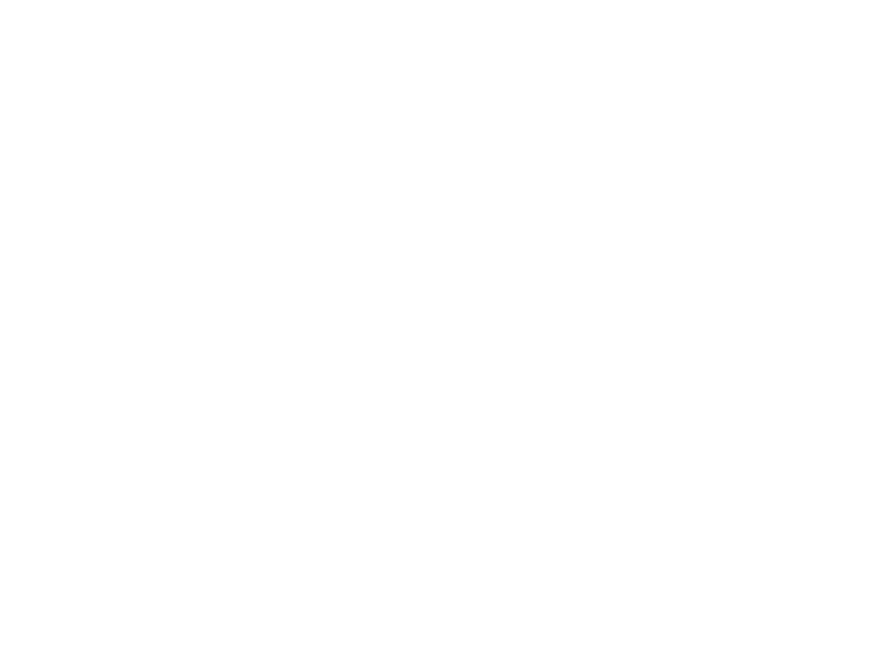

KeyboardInterrupt: 

In [16]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

index_rem = 0

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 20 == 0:
        ax.clear()
        
        for rows in range(num_row_arms):
            # check if any fruit was picked at this time
            if fruit_removal[rows][3, index_rem] < time_of_loop:
                # add the fruit index to be plotted
                index_plt = index_rem
                index_rem += 1
        
        ax.scatter(sortedFruit[0,:], sortedFruit[1,:], sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem], fruit_removal[rows][1,:index_rem], fruit_removal[rows][2,:index_rem], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()

